In [ ]:
!pip install google-cloud-aiplatform google-cloud-storage tensorflow pandas numpy scikit-learn matplotlib

In [ ]:
from google.colab import auth
auth.authenticate_user()

# Set Google Cloud project
!gcloud auth application-default login
!gcloud config set project rock-drake-443619-f2  # Replace with your actual GCP project ID



You are running on a Google Compute Engine virtual machine.
The service credentials associated with this virtual machine
will automatically be used by Application Default
Credentials, so it is not necessary to use this command.

If you decide to proceed anyway, your user credentials may be visible
to others with access to this virtual machine. Are you sure you want
to authenticate with your personal account?

Do you want to continue (Y/n)?  Y

Go to the following link in your browser, and complete the sign-in prompts:

    https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=764086051850-6qr4p6gpi6hn506pt8ejuq83di341hur.apps.googleusercontent.com&redirect_uri=https%3A%2F%2Fsdk.cloud.google.com%2Fapplicationdefaultauthcode.html&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fsqlservice.login&state=gZf1L5Ds9LZgpmIecVr785JpEU3W2k&prompt=consent&token_

In [ ]:
!gcloud auth application-default set-quota-project rock-drake-443619-f2
!gcloud services enable aiplatform.googleapis.com
!gcloud services enable storage.googleapis.com


Credentials saved to file: [/content/.config/application_default_credentials.json]

These credentials will be used by any library that requests Application Default Credentials (ADC).

Quota project "rock-drake-443619-f2" was added to ADC which can be used by Google client libraries for billing and quota. Note that some services may still bill the project owning the resource.


In [ ]:
!gcloud auth list
!gcloud config list

   Credentialed Accounts
ACTIVE  ACCOUNT
*       arnavak55@gmail.com

To set the active account, run:
    $ gcloud config set account `ACCOUNT`

[component_manager]
disable_update_check = True
[core]
account = arnavak55@gmail.com
project = rock-drake-443619-f2

Your active configuration is: [default]


In [ ]:
from google.cloud import storage
import pandas as pd
import io

# Define GCS bucket name and file path
bucket_name = "time-series-plume-data"  # Replace with your GCS bucket
file_path = "Merged_Thermistor_Data.csv"  # File stored in GCS

# Initialize GCS client
client = storage.Client()
bucket = client.bucket(bucket_name)
blob = bucket.blob(file_path)

# Load CSV file into pandas DataFrame
data = blob.download_as_text()
df = pd.read_csv(io.StringIO(data), parse_dates=["Time"])

print("Data loaded successfully from GCS!")
df.head()


Data loaded successfully from GCS!


,Time,Temperature,Temp_Diff,Thermistor_ID
0,2023-04-11 17:09:30.000,23.278053,-0.000352,T1
1,2023-04-11 17:09:30.063,23.277909,-0.000144,T1
2,2023-04-11 17:09:30.125,23.277637,-0.000272,T1
3,2023-04-11 17:09:30.188,23.277627,-0.000011,T1
4,2023-04-11 17:09:30.250,23.277627,0.000000,T1


In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Normalize Temp_Diff for all thermistors
scaler = MinMaxScaler()
df["Temp_Diff"] = scaler.fit_transform(df[["Temp_Diff"]])

# Sort by Time (ensure correct sequence order)
df = df.sort_values(by="Time")

print("Data preprocessing complete!")

Data preprocessing complete!


In [ ]:
import numpy as np

# Convert time series into sequences
def create_sequences(data, seq_length=10):
    sequences = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i : i + seq_length])
    return np.array(sequences)

seq_length = 10  # Number of past time steps we use to predict
X_train = create_sequences(df["Temp_Diff"].values, seq_length=seq_length)

print("Training Data Shape:", X_train.shape)


Training Data Shape: (349919, 10)


In [ ]:
import tensorflow as tf
print("GPU Available:", tf.config.list_physical_devices('GPU'))

GPU Available: []


In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

# Define LSTM Autoencoder Model
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, return_sequences=True, input_shape=(seq_length, 1)),
    tf.keras.layers.LSTM(32, return_sequences=False),
    tf.keras.layers.RepeatVector(seq_length),
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1))
])

model.compile(optimizer="adam", loss="mse")
model.summary()


early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(X_train, X_train, epochs=10, batch_size=64, validation_split=0.1, callbacks=[early_stop])





/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                        │ (None, 10, 64)              │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector_1 (RepeatVector)       │ (None, 10, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_6 (LSTM)                        │ (None, 10, 32)              │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 10, 64)              │          24,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 10, 1)               │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 62,529 (244.25 KB)

 Trainable params: 62,529 (244.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
4921/4921 ━━━━━━━━━━━━━━━━━━━━ 158s 30ms/step - loss: 0.0033 - val_loss: 2.1584e-05
Epoch 2/10
4921/4921 ━━━━━━━━━━━━━━━━━━━━ 201s 29ms/step - loss: 1.2984e-04 - val_loss: 2.4729e-05
Epoch 3/10
4921/4921 ━━━━━━━━━━━━━━━━━━━━ 200s 29ms/step - loss: 1.1950e-04 - val_loss: 1.5476e-05
Epoch 4/10
4921/4921 ━━━━━━━━━━━━━━━━━━━━ 203s 29ms/step - loss: 1.0319e-04 - val_loss: 2.0496e-05
Epoch 5/10
4921/4921 ━━━━━━━━━━━━━━━━━━━━ 205s 30ms/step - loss: 8.8005e-05 - val_loss: 1.1288e-05
Epoch 6/10
4921/4921 ━━━━━━━━━━━━━━━━━━━━ 200s 29ms/step - loss: 7.8360e-05 - val_loss: 1.0574e-05
Epoch 7/10
4921/4921 ━━━━━━━━━━━━━━━━━━━━ 204s 30ms/step - loss: 6.6359e-05 - val_loss: 1.2496e-05
Epoch 8/10
4921/4921 ━━━━━━━━━━━━━━━━━━━━ 202s 30ms/step - loss: 5.3176e-05 - val_loss: 9.0770e-06
Epoch 9/10
4921/4921 ━━━━━━━━━━━━━━━━━━━━ 202s 30ms/step - loss: 3.8298e-05 - val_loss: 7.4140e-06
Epoch 10/10
4921/4921 ━━━━━━━━━━━━━━━━━━━━ 201s 29ms/step - loss: 3.0229e-05 - val_loss: 8.0964e-06


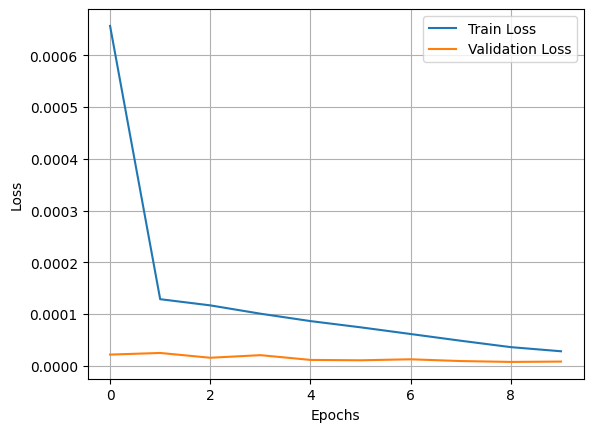

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

In [ ]:
print("X_train shape:", X_train.shape)


X_train shape: (349919, 10)


In [ ]:
X_pred = model.predict(X_train)

X_train_reshaped = X_train.reshape(-1, seq_length, 1)

# Compute Mean Absolute Error (MAE) loss
loss = np.mean(np.abs(X_pred - X_train_reshaped), axis=(1,2))

print("Loss calculated successfully!")



10935/10935 ━━━━━━━━━━━━━━━━━━━━ 81s 7ms/step
Loss calculated successfully!


In [ ]:
threshold = np.percentile(loss, 99)
# Trim the DataFrame to align with loss
df_trimmed = df.iloc[seq_length:].reset_index(drop=True)

df_trimmed["Anomaly"] = loss > threshold

# Save anomalies
df_trimmed.to_csv("Merged_Anomalies.csv", index=False)
print("Anomalies detected and saved locally!")

Anomalies detected and saved locally!


In [ ]:
import os
print(os.listdir())  # Lists all files in the current working directory

['.config', 'Merged_Anomalies.csv', 'sample_data']


In [ ]:
import pandas as pd

# Load the anomaly detection results
df_anomalies = pd.read_csv("Merged_Anomalies.csv", parse_dates=["Time"])

# Display the first few rows
print(df_anomalies.head())


                     Time  Temperature  Temp_Diff Thermistor_ID  Anomaly
0 2023-04-11 17:09:30.063    23.606044   0.444567           T17    False
1 2023-04-11 17:09:30.063    23.277909   0.444250            T1    False
2 2023-04-11 17:09:30.063    23.513256   0.444314           T13    False
3 2023-04-11 17:09:30.063    23.481439   0.444514           T12    False
4 2023-04-11 17:09:30.063    23.265192   0.444294            T2    False


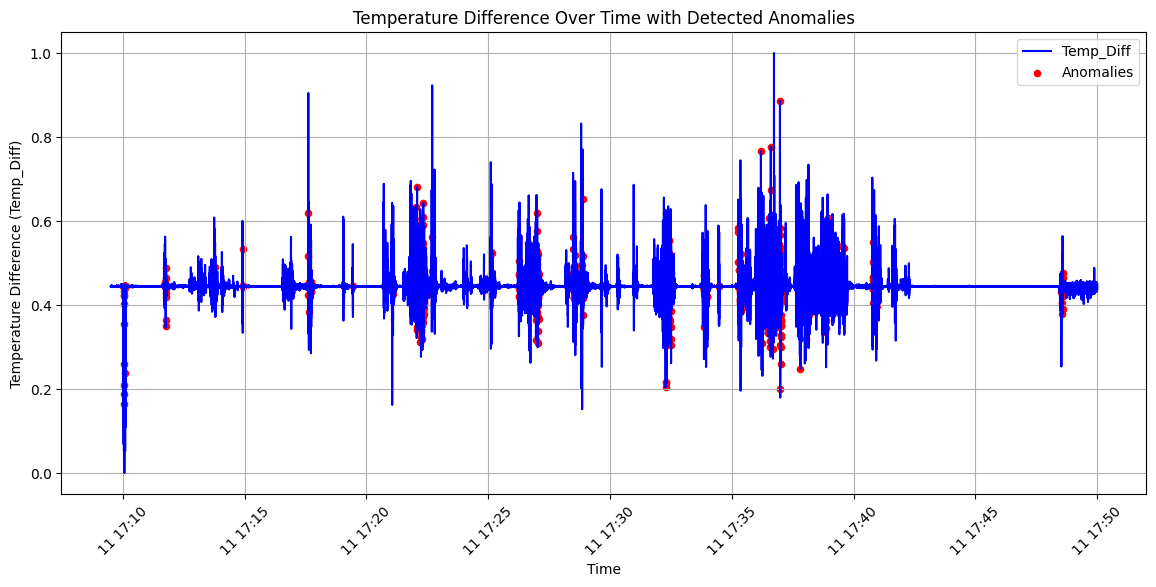

In [ ]:
import matplotlib.pyplot as plt

# Plot all data points
plt.figure(figsize=(14, 6))
plt.plot(df_anomalies["Time"], df_anomalies["Temp_Diff"], label="Temp_Diff", color="blue")

# Overlay anomalies in red
anomaly_points = df_anomalies[df_anomalies["Anomaly"] == True]
plt.scatter(anomaly_points["Time"], anomaly_points["Temp_Diff"], color="red", label="Anomalies", s=20)

# Formatting
plt.title("Temperature Difference Over Time with Detected Anomalies")
plt.xlabel("Time")
plt.ylabel("Temperature Difference (Temp_Diff)")
plt.legend()
plt.xticks(rotation=45)
plt.grid()
plt.show()


In [ ]:
# Count anomalies per thermistor
anomaly_counts = df_anomalies[df_anomalies["Anomaly"] == True]["Thermistor_ID"].value_counts()

# Display anomaly counts
print("Anomalies Detected per Thermistor:")
print(anomaly_counts)


Anomalies Detected per Thermistor:
Thermistor_ID
T17    435
T16    432
T7     415
T13    411
T12    397
T4     390
T2     370
T3     364
T1     286
Name: count, dtype: int64


<ipython-input-27-bdc2886872ab>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=anomaly_counts.index, y=anomaly_counts.values, palette="Reds")


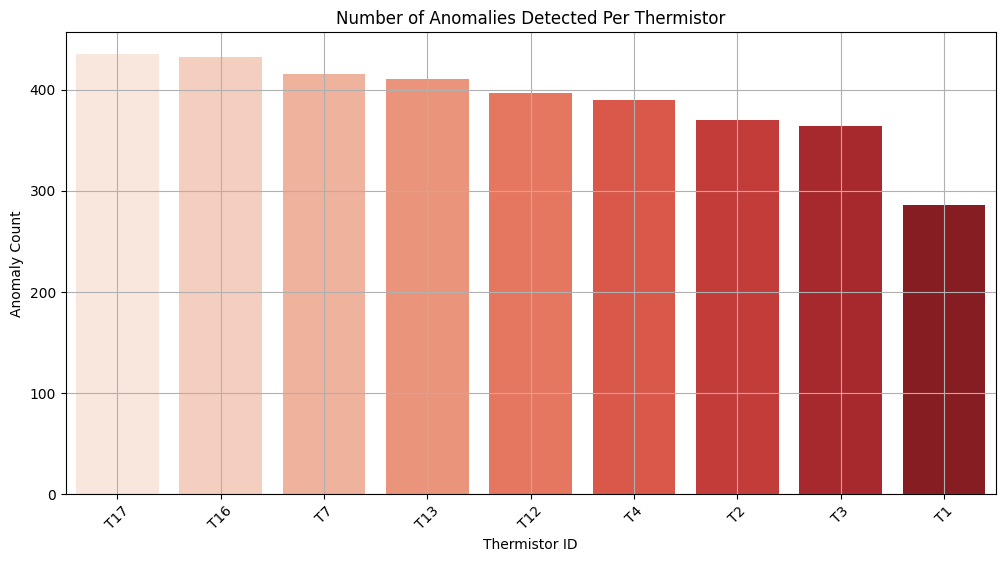

In [ ]:
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.barplot(x=anomaly_counts.index, y=anomaly_counts.values, palette="Reds")

plt.title("Number of Anomalies Detected Per Thermistor")
plt.xlabel("Thermistor ID")
plt.ylabel("Anomaly Count")
plt.xticks(rotation=45)
plt.grid()
plt.show()


<ipython-input-28-216bc8d7131d>:2: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_anomalies["Time_rounded"] = df_anomalies["Time"].dt.floor("5T")


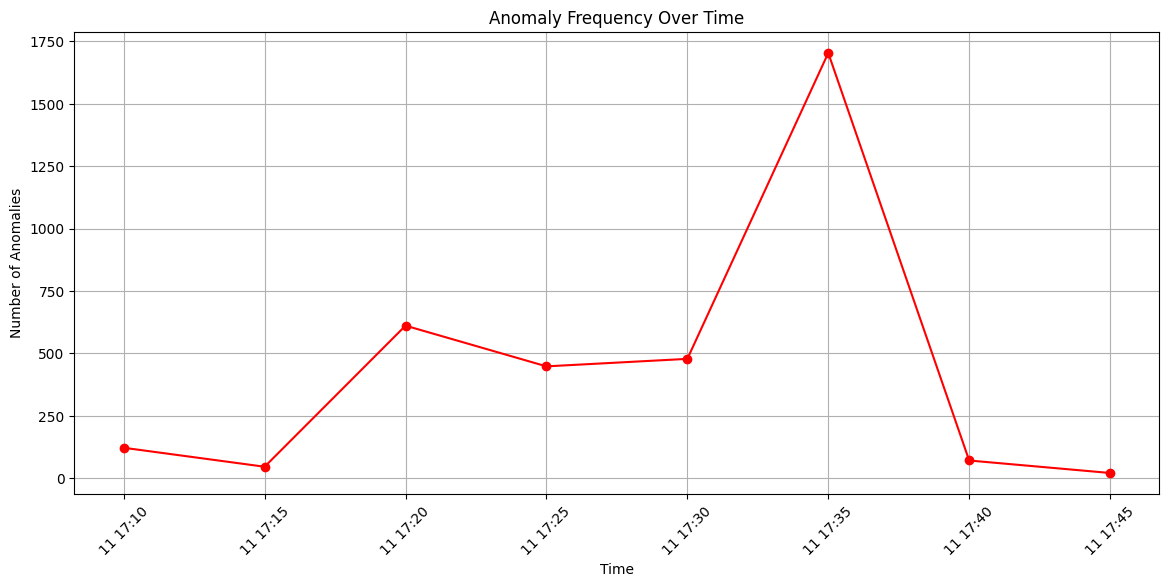

In [ ]:
# Group anomalies by time intervals (e.g., every 5 minutes)
df_anomalies["Time_rounded"] = df_anomalies["Time"].dt.floor("5T")
anomaly_trend = df_anomalies[df_anomalies["Anomaly"] == True].groupby("Time_rounded").size()

# Plot anomaly trend over time
plt.figure(figsize=(14, 6))
plt.plot(anomaly_trend.index, anomaly_trend.values, marker="o", linestyle="-", color="red")

plt.title("Anomaly Frequency Over Time")
plt.xlabel("Time")
plt.ylabel("Number of Anomalies")
plt.xticks(rotation=45)
plt.grid()
plt.show()


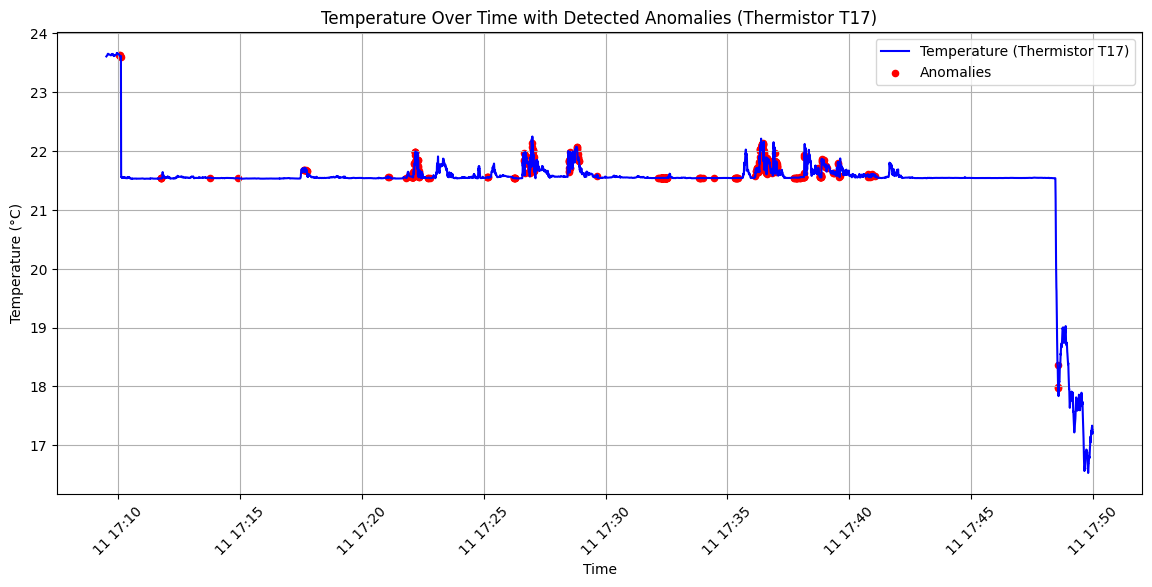

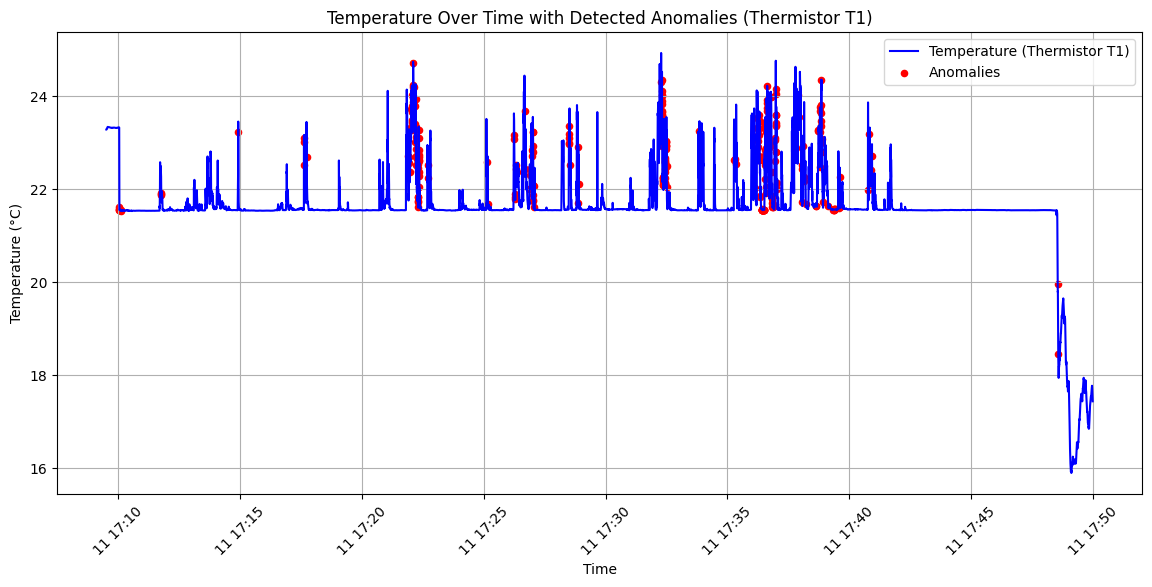

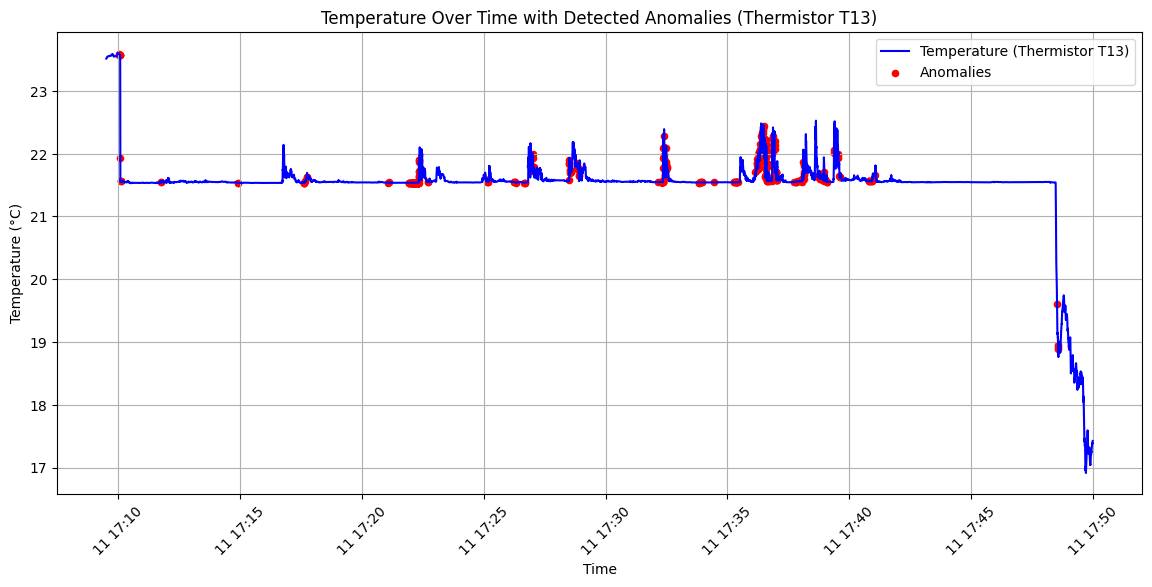

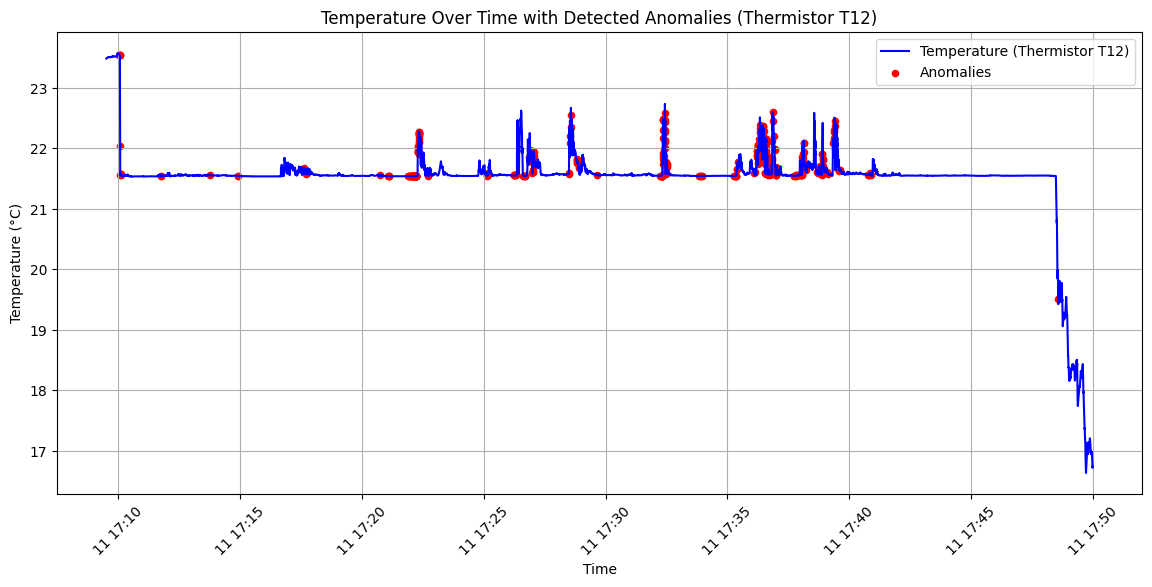

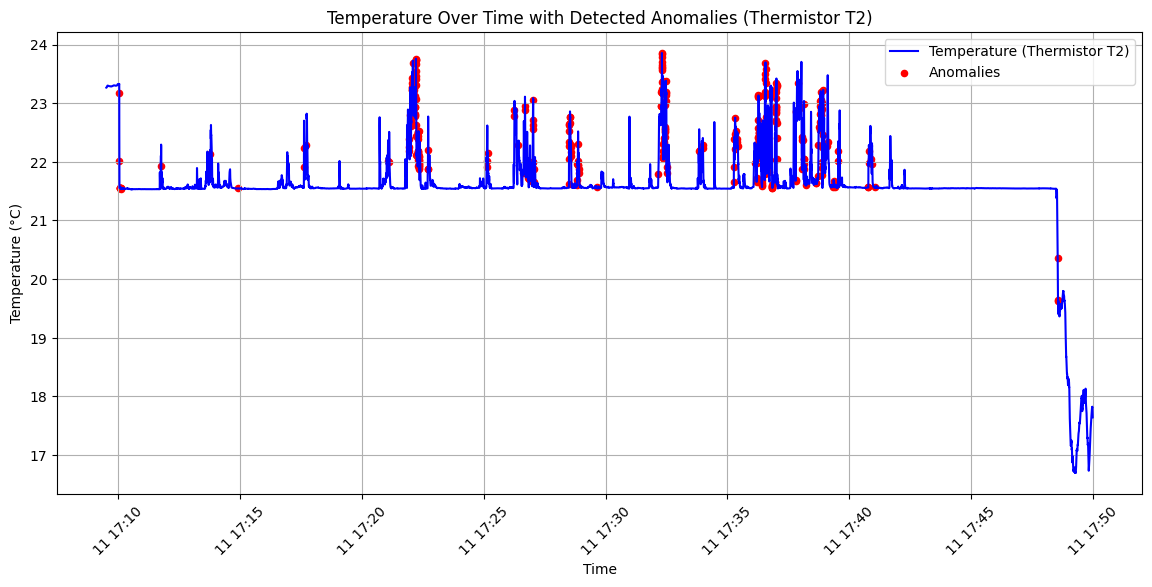

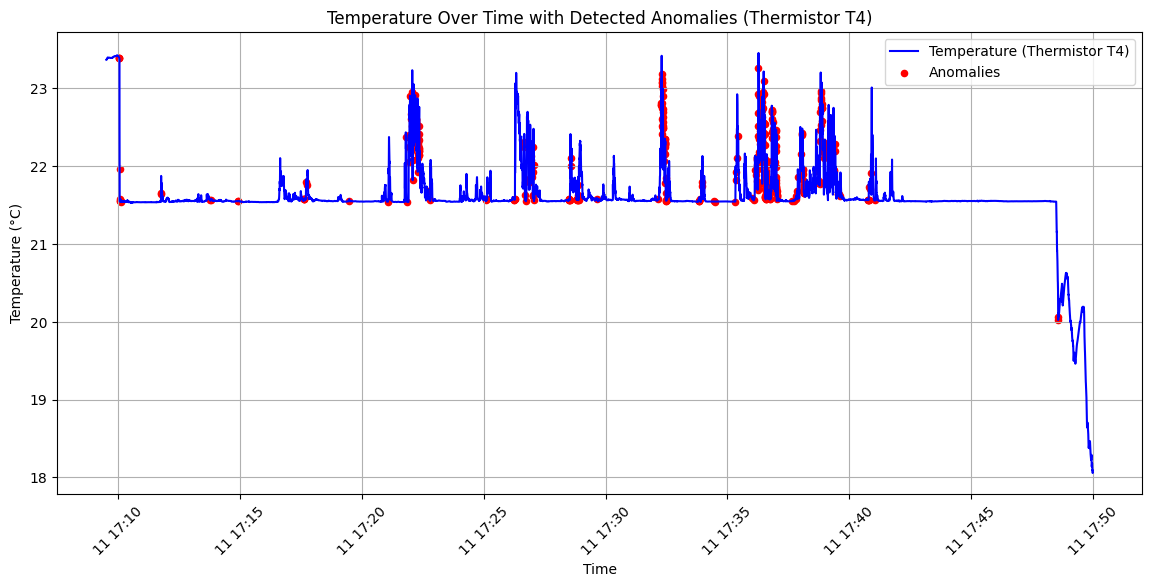

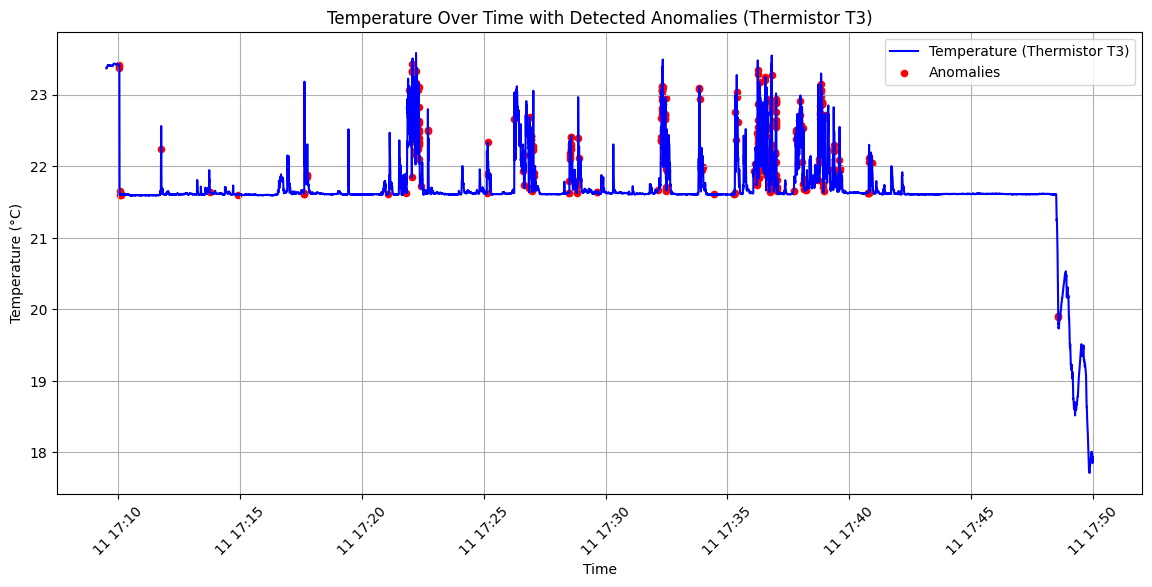

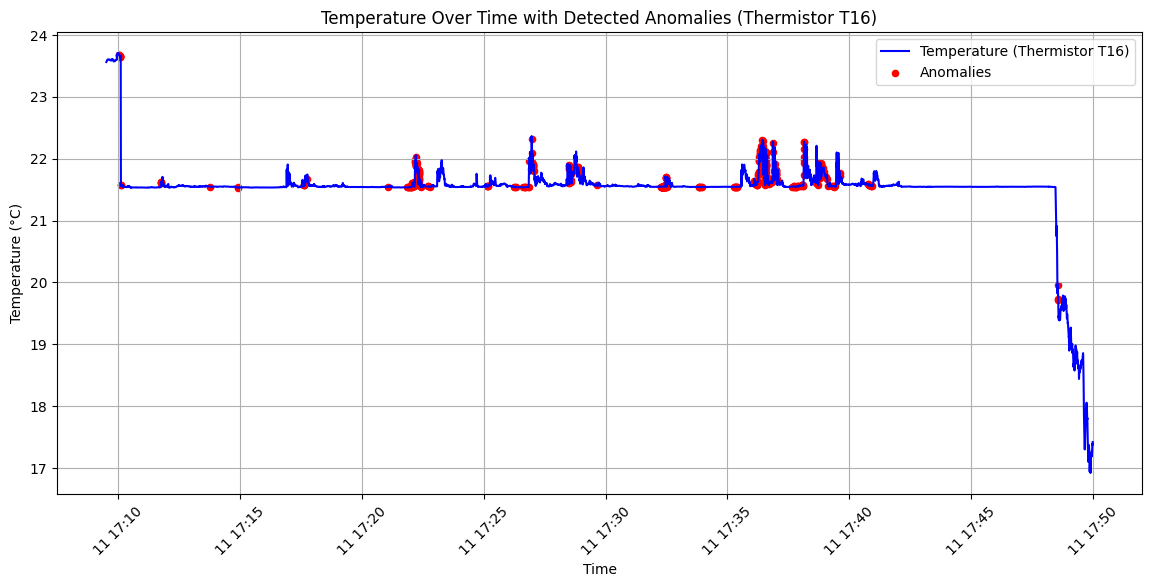

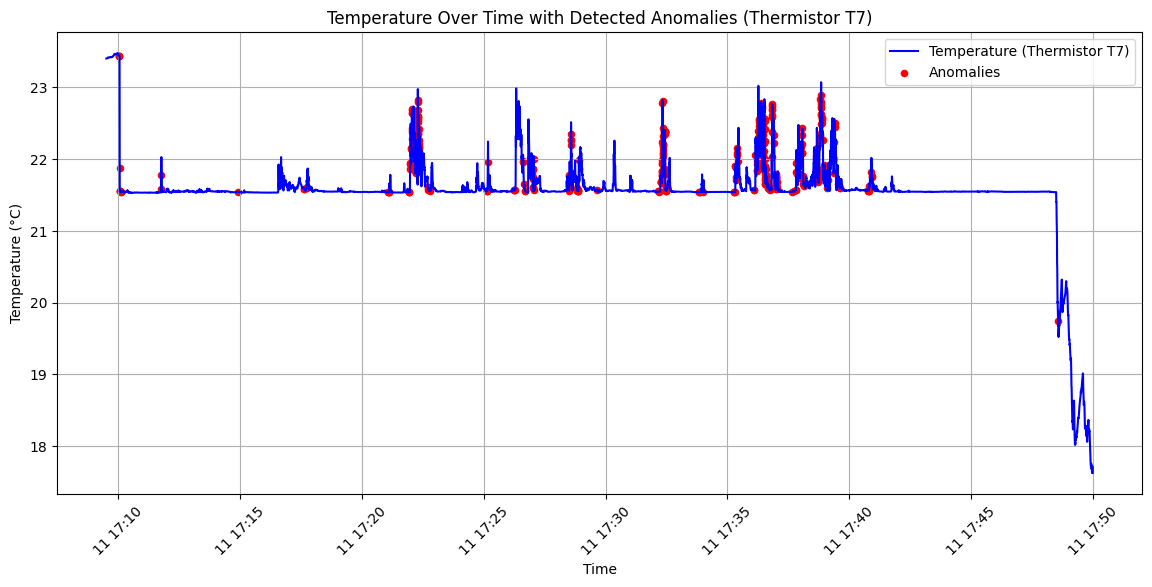

In [ ]:
import matplotlib.pyplot as plt

# Ensure anomalies are treated as boolean
df_anomalies["Anomaly"] = df_anomalies["Anomaly"].astype(bool)

# Unique thermistor IDs
thermistor_ids = df_anomalies["Thermistor_ID"].unique()

# Create a graph for each thermistor
for thermistor in thermistor_ids:
    plt.figure(figsize=(14, 6))

    # Filter data for the specific thermistor
    df_thermistor = df_anomalies[df_anomalies["Thermistor_ID"] == thermistor]

    # Plot temperature over time
    plt.plot(df_thermistor["Time"], df_thermistor["Temperature"], label=f"Temperature (Thermistor {thermistor})", color="blue")

    # Overlay anomalies in red
    anomaly_points = df_thermistor[df_thermistor["Anomaly"] == True]
    plt.scatter(anomaly_points["Time"], anomaly_points["Temperature"], color="red", label="Anomalies", s=20)

    # Formatting
    plt.title(f"Temperature Over Time with Detected Anomalies (Thermistor {thermistor})")
    plt.xlabel("Time")
    plt.ylabel("Temperature (°C)")
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid()

    # Show the graph
    plt.show()


In [ ]:
# Count total number of anomalies
total_anomalies = df_anomalies["Anomaly"].sum()

# Display the total count of anomalies
print(f"Total Number of Anomalies Detected: {total_anomalies}")


Total Number of Anomalies Detected: 3500


In [ ]:
# Filter anomalies
df_anomalies_only = df_anomalies[df_anomalies["Anomaly"] == True].reset_index(drop=True)
print(f"Number of anomalies: {len(df_anomalies_only)}")


Number of anomalies: 3500


In [ ]:
df_anomalies_only["Temp_Diff"] = df_anomalies_only["Temperature"].diff()
df_anomalies_only["Thermistor_Num"] = df_anomalies_only["Thermistor_ID"].astype("category").cat.codes
df_anomalies_only["Time_Diff"] = df_anomalies_only["Time"].diff().dt.total_seconds()
df_anomalies_only = df_anomalies_only.fillna(0)

In [ ]:
df_anomalies_only["Time_Num"] = df_anomalies_only["Time"].astype('int64') // 10**9

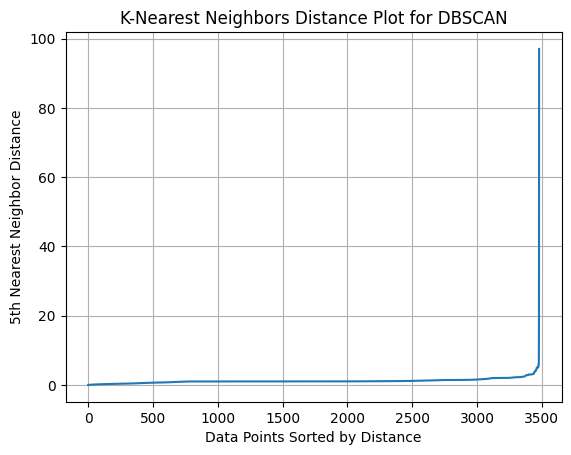

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

# Select features used for clustering
features = df_anomalies_only[["Time_Num", "Thermistor_Num", "Temp_Diff"]]

# Compute k-nearest neighbor distances (k=5)
neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(features)
distances, indices = neighbors_fit.kneighbors(features)

# Sort distances and plot
sorted_distances = np.sort(distances[:, -1])  # Take the 5th nearest neighbor distance
plt.plot(sorted_distances)
plt.xlabel("Data Points Sorted by Distance")
plt.ylabel("5th Nearest Neighbor Distance")
plt.title("K-Nearest Neighbors Distance Plot for DBSCAN")
plt.grid()
plt.show()


In [ ]:
from sklearn.cluster import DBSCAN

# Select features for clustering
clustering_features = df_anomalies_only[["Time_Num", "Thermistor_Num", "Temp_Diff"]]

# Apply DBSCAN
dbscan = DBSCAN(eps=6, min_samples=5)  # Adjust eps for better grouping
df_anomalies_only["Orifice_Cluster"] = dbscan.fit_predict(clustering_features)

# Count unique clusters (orifices)
num_orifices = len(set(df_anomalies_only["Orifice_Cluster"]) - {-1})  # Ignore noise cluster (-1)
print(f"Estimated Number of Orifices: {num_orifices}")

Estimated Number of Orifices: 19


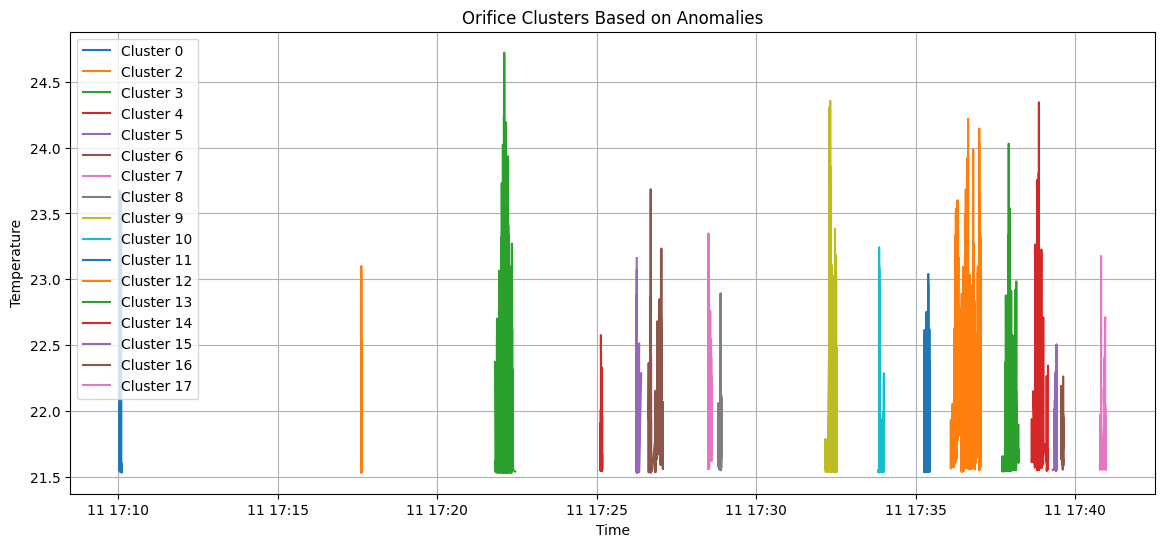

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
for cluster in df_anomalies_only["Orifice_Cluster"].unique():
    if cluster == -1:
        continue  # Skip noise cluster
    cluster_data = df_anomalies_only[df_anomalies_only["Orifice_Cluster"] == cluster]
    plt.plot(cluster_data["Time"], cluster_data["Temperature"], label=f"Cluster {cluster}")

plt.title("Orifice Clusters Based on Anomalies")
plt.xlabel("Time")
plt.ylabel("Temperature")
plt.legend()
plt.grid()
plt.show()


In [ ]:
cluster_sizes = df_anomalies_only["Orifice_Cluster"].value_counts()
print("Cluster Sizes:")
print(cluster_sizes)

Cluster Sizes:
Orifice_Cluster
12    1078
3      567
9      430
14     259
13     202
6      188
7       99
0       81
8       80
11      77
17      67
15      48
10      43
5       39
16      35
4       34
2       28
1       21
18      21
Name: count, dtype: int64


In [ ]:
min_cluster_size = max(10, df_anomalies_only["Orifice_Cluster"].value_counts().quantile(0.1))  # 10th percentile

# Keep clusters above the new threshold
valid_clusters = df_anomalies_only["Orifice_Cluster"].value_counts()[df_anomalies_only["Orifice_Cluster"].value_counts() >= min_cluster_size].index
df_anomalies_only = df_anomalies_only[df_anomalies_only["Orifice_Cluster"].isin(valid_clusters)]

num_orifices_refined = len(valid_clusters)
print(f"Refined Estimated Number of Orifices: {num_orifices_refined}")

Refined Estimated Number of Orifices: 17


In [ ]:
# Compute variance of temperature difference within each cluster
cluster_variance_temp_diff = df_anomalies_only.groupby("Orifice_Cluster")["Temp_Diff"].var()

# Display clusters with high variance
print(cluster_variance_temp_diff.sort_values(ascending=False))


Orifice_Cluster
17    1.515064
0     1.382136
11    0.802488
6     0.718220
14    0.481639
3     0.470606
12    0.455839
15    0.443415
8     0.338267
13    0.337053
4     0.230576
9     0.227044
7     0.158500
16    0.124026
1     0.068568
5     0.046411
Name: Temp_Diff, dtype: float64


In [ ]:
# Find the 90th percentile of variance (top 10% highest variance clusters)
variance_threshold = cluster_variance_temp_diff.quantile(0.90)

print(f"Variance threshold for potential merged clusters: {variance_threshold:.4f}")


Variance threshold for potential merged clusters: 1.0923


In [ ]:
# Identify clusters with high variance in Temp_Diff
merged_clusters = cluster_variance_temp_diff[cluster_variance_temp_diff > variance_threshold].index

print(f"Clusters with high Temp_Diff variance (possible merges): {list(merged_clusters)}")


Clusters with high Temp_Diff variance (possible merges): [0, 17]


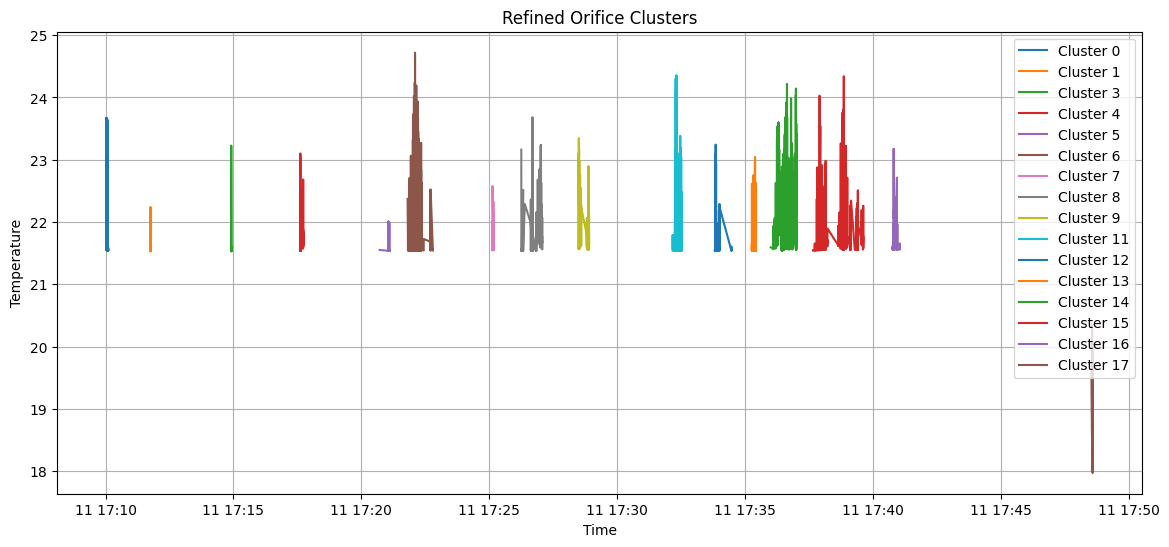

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
for cluster in df_anomalies_only["Orifice_Cluster"].unique():
    if cluster == -1:
        continue  # Skip noise cluster
    cluster_data = df_anomalies_only[df_anomalies_only["Orifice_Cluster"] == cluster]
    plt.plot(cluster_data["Time"], cluster_data["Temperature"], label=f"Cluster {cluster}")

plt.title("Refined Orifice Clusters")
plt.xlabel("Time")
plt.ylabel("Temperature")
plt.legend()
plt.grid()
plt.show()


In [ ]:
# Get thermistors in full dataset and detected anomalies
all_thermistors = set(df_anomalies["Thermistor_ID"].unique())
detected_thermistors = set(df_anomalies_only["Thermistor_ID"].unique())

# Identify thermistors that did not detect any orifices
missing_thermistors = all_thermistors - detected_thermistors

print(f"Thermistors that did NOT detect orifices: {missing_thermistors}")


Thermistors that did NOT detect orifices: set()


In [ ]:
# Compute temperature variance for each cluster
cluster_variance = df_anomalies_only.groupby("Orifice_Cluster")["Temperature"].std()

# Find high-variance clusters (possible merges)
high_variance_clusters = cluster_variance[cluster_variance > 0]  # Adjust threshold as needed

#print(f"Clusters with high variance (possible merges): {high_variance_clusters}")

print(cluster_variance)


Orifice_Cluster
-1     0.524905
 0     0.976762
 1     0.423342
 3     0.734038
 4     0.381859
 5     0.225383
 6     0.497625
 7     0.338437
 8     0.322437
 9     0.217415
 10    0.745736
 11    0.469149
 13    0.439525
 14    0.448481
 15    0.455898
 16    0.442972
 17    0.558763
 18    0.463039
 19    0.331836
 20    0.620784
 21    0.318981
 22    0.326898
 23    0.293794
Name: Temperature, dtype: float64
